<a href="https://colab.research.google.com/github/jiinpark21/ESAA_24-2/blob/main/10%EC%A3%BC%EC%B0%A8_%EA%B3%BC%EC%A0%9C_1104_%EC%B6%94%EC%B2%9C%EC%8B%9C%EC%8A%A4%ED%85%9C_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

파이썬 머신러닝 완벽가이드 개정2판 ch9. 6~9

p.613-647

# [Chapter 9] 추천 시스템

## 9-6. 아이템 기반 최근접 이웃 협업 필터링 실습

- 최근접 이웃 협업 필터링
  - 사용자 기반
  - 아이템 기반 : 일반적으로 추천 정확도가 더 뛰어남

### 데이터 가공 및 변환

In [2]:
import pandas as pd
import numpy as np

movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
print(movies.shape)
print(ratings.shape)

(9742, 3)
(100836, 4)


- userId : 사용자 아이디
- movieId : 영화 아이디
- rating : 평점

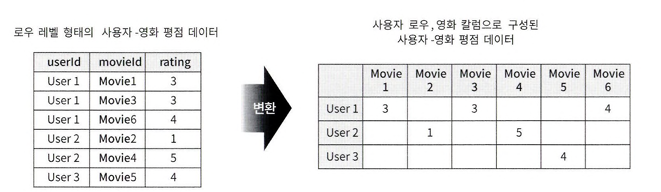

- 로우 레벨 형태의 원본 데이터 세트를 그림과 같이 사용자를 로우, 영화를 칼럼을 구성한 데이터 세트로 변경해야 함
  - pivot_table() : 로우 레벨의 값을 칼럼으로 변경

In [3]:
ratings = ratings[['userId', 'movieId', 'rating']]
ratings_matrix = ratings.pivot_table('rating', index='userId', columns='movieId')
ratings_matrix.head(3)

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- 최소 평점이 0.5이므로 NaN은 모두 0으로 변환

In [4]:
# title 칼럼을 얻기 위해 movies와 조인
rating_movies = pd.merge(ratings,movies, on='movieId')

# columns='title'로 title 칼럼으로 피벗 수행.
ratings_matrix = rating_movies.pivot_table('rating', index='userId', columns='title')

# NaN 값을 모두 0으로 변환
ratings_matrix = ratings_matrix.fillna(0)
ratings_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 영화 간 유사도 산출

- 영화간의 유사도는 코사인 유사도를 기반으로 계산, cosine_similarity() 이용
- ratings_matrix로 영화간 유사도 측정 불가
  - 행을 기준으로 서로 다른 행을 비교해 유사도를 계산하므로 cosine_similarity() 적용 시 사용자 간의 유사도가 만들어짐
  - 행과 열 위치 바꾸기 위해 -> transpose() 적용

In [5]:
ratings_matrix_T = ratings_matrix.transpose()
ratings_matrix_T.head(3)

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
'Hellboy': The Seeds of Creation (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Round Midnight (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
from sklearn.metrics.pairwise import cosine_similarity

item_sim = cosine_similarity(ratings_matrix_T, ratings_matrix_T)

# cosine_similarity()로 반환된 넘파이 행렬을 영화명을 매핑해 DataFrame으로 변환
item_sim_df = pd.DataFrame(data=item_sim, index=ratings_matrix.columns,
                           columns=ratings_matrix.columns)
print(item_sim_df.shape)
item_sim_df.head(3)

(9719, 9719)


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),1.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.141653,0.0,...,0.0,0.342055,0.543305,0.707107,0.0,0.0,0.139431,0.327327,0.0,0.0
'Hellboy': The Seeds of Creation (2004),0.0,1.000000,0.707107,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
'Round Midnight (1986),0.0,0.707107,1.000000,0.0,0.0,0.0,0.176777,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0


- item_sim_df에서 "Godfather, The (1972)"와 유사도가 높은 상위 6개 영화 추출

In [ ]:
item_sim_df["Godfather, The (1972)"].sort_values(ascending=False)[:6]

,"Godfather, The (1972)"
title,
"Godfather, The (1972)",1.000000
"Godfather: Part II, The (1974)",0.821773
Goodfellas (1990),0.664841
One Flew Over the Cuckoo's Nest (1975),0.620536
Star Wars: Episode IV - A New Hope (1977),0.595317
Fargo (1996),0.588614


- 앞선 콘텐츠 기반 필터링과 다른점은 장르가 완전히 다른 영화(스타워즈 등)도 유사도가 매우 높게 나타남

In [7]:
item_sim_df["Inception (2010)"].sort_values(ascending=False)[1:6]

,Inception (2010)
title,
"Dark Knight, The (2008)",0.727263
Inglourious Basterds (2009),0.646103
Shutter Island (2010),0.617736
"Dark Knight Rises, The (2012)",0.617504
Fight Club (1999),0.615417


-------------------------------------------------------

### 아이템 기반 최근접 이웃 협업 필터링으로 개인화된 영화 추천

- 영화 유사도 데이터를 이용해 최근접 이웃 협업 필터링으로 개인에게 최적화된 영화 추천 구현
  - 개인이 아직 관람하지 않은 영화 추천
  - 아직 관람하지 않은 영화에 대해 아이템 유사도와 기존에 관람한 영화의 평점 데이터를 기반으로 새롭게 모든 영화의 예측 평점 계산 후, 높은 예측 평점을 가진 영화 추천

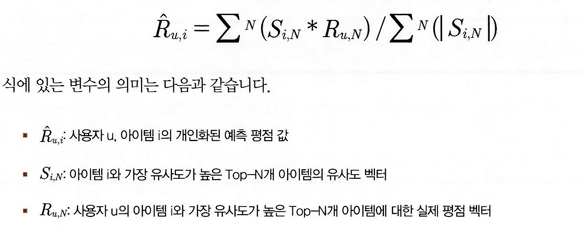

- N : 아이템의 최근접 이웃 범위 계수
  - 특정 아이템과 유사도가 가장 높은 Top-N개의 다른 아이템 추출하는데 사용

- predict_rating() : 사용자별로 최적화도니 평점 스코어 예측하는 함수

In [ ]:
def predict_rating(ratings_arr, item_sim_arr ):
    ratings_pred = ratings_arr.dot(item_sim_arr)/ np.array([np.abs(item_sim_arr).sum(axis=1)])
    return ratings_pred

In [ ]:
ratings_pred = predict_rating(ratings_matrix.values , item_sim_df.values)
ratings_pred_matrix = pd.DataFrame(data=ratings_pred, index= ratings_matrix.index,
                                   columns = ratings_matrix.columns)
ratings_pred_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.070345,0.577855,0.321696,0.227055,0.206958,0.194615,0.249883,0.102542,0.157084,0.178197,...,0.113608,0.181738,0.133962,0.128574,0.006179,0.212070,0.192921,0.136024,0.292955,0.720347
2,0.018260,0.042744,0.018861,0.000000,0.000000,0.035995,0.013413,0.002314,0.032213,0.014863,...,0.015640,0.020855,0.020119,0.015745,0.049983,0.014876,0.021616,0.024528,0.017563,0.000000
3,0.011884,0.030279,0.064437,0.003762,0.003749,0.002722,0.014625,0.002085,0.005666,0.006272,...,0.006923,0.011665,0.011800,0.012225,0.000000,0.008194,0.007017,0.009229,0.010420,0.084501


In [ ]:
from sklearn.metrics import mean_squared_error

# 사용자가 평점을 부여한 영화에 대해서만 예측 성능 평가 MSE 를 구함.
def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

print('아이템 기반 모든 인접 이웃 MSE: ', get_mse(ratings_pred, ratings_matrix.values ))

아이템 기반 모든 인접 이웃 MSE:  9.895354759094706


In [ ]:
def predict_rating_topsim(ratings_arr, item_sim_arr, n=20):
    # 사용자-아이템 평점 행렬 크기만큼 0으로 채운 예측 행렬 초기화
    pred = np.zeros(ratings_arr.shape)

    # 사용자-아이템 평점 행렬의 열 크기만큼 Loop 수행.
    for col in range(ratings_arr.shape[1]):
        # 유사도 행렬에서 유사도가 큰 순으로 n개 데이터 행렬의 index 반환
        top_n_items = [np.argsort(item_sim_arr[:, col])[:-n-1:-1]]
        # 개인화된 예측 평점을 계산
        for row in range(ratings_arr.shape[0]):
            pred[row, col] = item_sim_arr[col, :][top_n_items].dot(ratings_arr[row, :][top_n_items].T)
            pred[row, col] /= np.sum(np.abs(item_sim_arr[col, :][top_n_items]))
    return pred

In [ ]:
ratings_pred = predict_rating_topsim(ratings_matrix.values , item_sim_df.values, n=20)
print('아이템 기반 인접 TOP-20 이웃 MSE: ', get_mse(ratings_pred, ratings_matrix.values ))


# 계산된 예측 평점 데이터는 DataFrame으로 재생성
ratings_pred_matrix = pd.DataFrame(data=ratings_pred, index= ratings_matrix.index,
                                   columns = ratings_matrix.columns)

<ipython-input-18-6a1571ba1895>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred[row, col] = item_sim_arr[col, :][top_n_items].dot(ratings_arr[row, :][top_n_items].T)


아이템 기반 인접 TOP-20 이웃 MSE:  3.6949827608772314


In [ ]:
user_rating_id = ratings_matrix.loc[9, :]
user_rating_id[ user_rating_id > 0].sort_values(ascending=False)[:10]

,9
title,
Adaptation (2002),5.0
Citizen Kane (1941),5.0
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),5.0
"Producers, The (1968)",5.0
"Lord of the Rings: The Two Towers, The (2002)",5.0
"Lord of the Rings: The Fellowship of the Ring, The (2001)",5.0
Back to the Future (1985),5.0
Austin Powers in Goldmember (2002),5.0
Minority Report (2002),4.0


In [ ]:
def get_unseen_movies(ratings_matrix, userId):
    # userId로 입력받은 사용자의 모든 영화정보 추출하여 Series로 반환함.
    # 반환된 user_rating 은 영화명(title)을 index로 가지는 Series 객체임.
    user_rating = ratings_matrix.loc[userId,:]

    # user_rating이 0보다 크면 기존에 관람한 영화임. 대상 index를 추출하여 list 객체로 만듬
    already_seen = user_rating[ user_rating > 0].index.tolist()

    # 모든 영화명을 list 객체로 만듬.
    movies_list = ratings_matrix.columns.tolist()

    # list comprehension으로 already_seen에 해당하는 movie는 movies_list에서 제외함.
    unseen_list = [ movie for movie in movies_list if movie not in already_seen]

    return unseen_list

In [ ]:
def recomm_movie_by_userid(pred_df, userId, unseen_list, top_n=10):
    # 예측 평점 DataFrame에서 사용자id index와 unseen_list로 들어온 영화명 컬럼을 추출하여
    # 가장 예측 평점이 높은 순으로 정렬함.
    recomm_movies = pred_df.loc[userId, unseen_list].sort_values(ascending=False)[:top_n]
    return recomm_movies

# 사용자가 관람하지 않는 영화명 추출
unseen_list = get_unseen_movies(ratings_matrix, 9)

# 아이템 기반의 인접 이웃 협업 필터링으로 영화 추천
recomm_movies = recomm_movie_by_userid(ratings_pred_matrix, 9, unseen_list, top_n=10)

# 평점 데이타를 DataFrame으로 생성.
recomm_movies = pd.DataFrame(data=recomm_movies.values,index=recomm_movies.index,columns=['pred_score'])
recomm_movies

,pred_score
title,
Shrek (2001),0.866202
Spider-Man (2002),0.857854
"Last Samurai, The (2003)",0.817473
Indiana Jones and the Temple of Doom (1984),0.816626
"Matrix Reloaded, The (2003)",0.800990
Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001),0.765159
Gladiator (2000),0.740956
"Matrix, The (1999)",0.732693
Pirates of the Caribbean: The Curse of the Black Pearl (2003),0.689591


## 9-7. 행렬 분해를 이용한 잠재 요인 협업 필터링 실습

- 행렬 분해 잠재 요인 협업 필터링
  - SVD, NMF 등 적용 가능
  - 일반적으로 행렬 분해에는 SVD가 자주 사용되지만, 사용자-아이템 평점 행렬에는 널 데이터가 많으므로 SGD나 ALS 기반의 행렬 분해 이용

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

def get_rmse(R, P, Q, non_zeros):
    error = 0
    # 두개의 분해된 행렬 P와 Q.T의 내적 곱으로 예측 R 행렬 생성
    full_pred_matrix = np.dot(P, Q.T)

    # 실제 R 행렬에서 널이 아닌 값의 위치 인덱스 추출하여 실제 R 행렬과 예측 행렬의 RMSE 추출
    x_non_zero_ind = [non_zero[0] for non_zero in non_zeros]
    y_non_zero_ind = [non_zero[1] for non_zero in non_zeros]
    R_non_zeros = R[x_non_zero_ind, y_non_zero_ind]

    full_pred_matrix_non_zeros = full_pred_matrix[x_non_zero_ind, y_non_zero_ind]

    mse = mean_squared_error(R_non_zeros, full_pred_matrix_non_zeros)
    rmse = np.sqrt(mse)

    return rmse

In [ ]:
def matrix_factorization(R, K, steps=200, learning_rate=0.01, r_lambda = 0.01):
    num_users, num_items = R.shape
    # P와 Q 매트릭스의 크기를 지정하고 정규분포를 가진 랜덤한 값으로 입력합니다.
    np.random.seed(1)
    P = np.random.normal(scale=1./K, size=(num_users, K))
    Q = np.random.normal(scale=1./K, size=(num_items, K))

    # R > 0 인 행 위치, 열 위치, 값을 non_zeros 리스트 객체에 저장.
    non_zeros = [ (i, j, R[i,j]) for i in range(num_users) for j in range(num_items) if R[i,j] > 0 ]

    # SGD기법으로 P와 Q 매트릭스를 계속 업데이트.
    for step in range(steps):
        for i, j, r in non_zeros:
            # 실제 값과 예측 값의 차이인 오류 값 구함
            eij = r - np.dot(P[i, :], Q[j, :].T)
            # Regularization을 반영한 SGD 업데이트 공식 적용
            P[i,:] = P[i,:] + learning_rate*(eij * Q[j, :] - r_lambda*P[i,:])
            Q[j,:] = Q[j,:] + learning_rate*(eij * P[i, :] - r_lambda*Q[j,:])

        rmse = get_rmse(R, P, Q, non_zeros)
        if (step % 10) == 0 :
            print("### iteration step : ", step," rmse : ", rmse)

    return P, Q

In [ ]:
import pandas as pd
import numpy as np

movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
ratings = ratings[['userId', 'movieId', 'rating']]
ratings_matrix = ratings.pivot_table('rating', index='userId', columns='movieId')

# title 컬럼을 얻기 이해 movies 와 조인 수행
rating_movies = pd.merge(ratings, movies, on='movieId')

# columns='title' 로 title 컬럼으로 pivot 수행
ratings_matrix = rating_movies.pivot_table('rating', index='userId', columns='title')

In [ ]:
P, Q = matrix_factorization(ratings_matrix.values, K=50, steps=200, learning_rate=0.01, r_lambda = 0.01)
pred_matrix = np.dot(P, Q.T)

### iteration step :  0  rmse :  2.9023619751336867
### iteration step :  10  rmse :  0.7335768591017927
### iteration step :  20  rmse :  0.5115539026853442
### iteration step :  30  rmse :  0.37261628282537446
### iteration step :  40  rmse :  0.2960818299181014
### iteration step :  50  rmse :  0.2520353192341642
### iteration step :  60  rmse :  0.22487503275269854
### iteration step :  70  rmse :  0.2068545530233154
### iteration step :  80  rmse :  0.19413418783028685
### iteration step :  90  rmse :  0.18470082002720406
### iteration step :  100  rmse :  0.17742927527209104
### iteration step :  110  rmse :  0.1716522696470749
### iteration step :  120  rmse :  0.16695181946871726
### iteration step :  130  rmse :  0.16305292191997542
### iteration step :  140  rmse :  0.15976691929679646
### iteration step :  150  rmse :  0.1569598699945732
### iteration step :  160  rmse :  0.15453398186715425
### iteration step :  170  rmse :  0.15241618551077643
### iteration step :  180  rm

In [ ]:
ratings_pred_matrix = pd.DataFrame(data=pred_matrix, index= ratings_matrix.index,
                                   columns = ratings_matrix.columns)

ratings_pred_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,3.055084,4.092018,3.564130,4.502167,3.981215,1.271694,3.603274,2.333266,5.091749,3.972454,...,1.402608,4.208382,3.705957,2.720514,2.787331,3.475076,3.253458,2.161087,4.010495,0.859474
2,3.170119,3.657992,3.308707,4.166521,4.311890,1.275469,4.237972,1.900366,3.392859,3.647421,...,0.973811,3.528264,3.361532,2.672535,2.404456,4.232789,2.911602,1.634576,4.135735,0.725684
3,2.307073,1.658853,1.443538,2.208859,2.229486,0.780760,1.997043,0.924908,2.970700,2.551446,...,0.520354,1.709494,2.281596,1.782833,1.635173,1.323276,2.887580,1.042618,2.293890,0.396941


In [ ]:
# 사용자가 관람하지 않는 영화명 추출
unseen_list = get_unseen_movies(ratings_matrix, 9)

# 아이템 기반의 인접 이웃 협업 필터링으로 영화 추천
recomm_movies = recomm_movie_by_userid(ratings_pred_matrix, 9, unseen_list, top_n=10)

# 평점 데이타를 DataFrame으로 생성.
recomm_movies = pd.DataFrame(data=recomm_movies.values,index=recomm_movies.index,columns=['pred_score'])
recomm_movies

,pred_score
title,
Rear Window (1954),5.704612
"South Park: Bigger, Longer and Uncut (1999)",5.451100
Rounders (1998),5.298393
Blade Runner (1982),5.244951
Roger & Me (1989),5.191962
Gattaca (1997),5.183179
Ben-Hur (1959),5.130463
Rosencrantz and Guildenstern Are Dead (1990),5.087375
"Big Lebowski, The (1998)",5.038690


## 9-8. 파이썬 추천 시스템 패키지 - Surprise

### Surprise 패키지 소개
- 다양한 추천 알고리즘, 사용자 또는 아이템 기반 최근접 이웃 협업 필터링, SVD, SVD++, NMF 기반의 잠재 요인 협업 필터링을 쉽게 적용해 추천 시스템 구축 가능

In [ ]:
pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 9.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357282 sha256=9be42ceb952859c57303442067a345315f9f2977302e014be82c5750c8a8ee90
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


### Surprise를 이용한 추천 시스템 구축

- Surprise에서 데이터 로딩은 Dataset 클래스를 이용해서만 가능

In [ ]:
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split

In [ ]:
data = Dataset.load_builtin('ml-100k')
# 수행 시마다 동일하게 데이터를 분할하기 위해 random_state 값 부여
trainset, testset = train_test_split(data, test_size=.25, random_state=0)

Dataset ml-100k could not be found. Do you want to download it? [Y/n] Y
Trying to download dataset from https://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k


In [ ]:
algo = SVD(random_state=0)
algo.fit(trainset)

- test() : 사용자-아이템 평점 데이터 세트 전체에 대해 추천을 예측하는 메서드
- predict() : 개별 사용자와 영화에 대한 추천 평점 반환

In [ ]:
predictions = algo.test( testset )
print('prediction type :',type(predictions), ' size:',len(predictions))
print('prediction 결과의 최초 5개 추출')
predictions[:5]

prediction type : <class 'list'>  size: 25000
prediction 결과의 최초 5개 추출


[Prediction(uid='120', iid='282', r_ui=4.0, est=3.5114147666251547, details={'was_impossible': False}),
 Prediction(uid='882', iid='291', r_ui=4.0, est=3.573872419581491, details={'was_impossible': False}),
 Prediction(uid='535', iid='507', r_ui=5.0, est=4.033583485472447, details={'was_impossible': False}),
 Prediction(uid='697', iid='244', r_ui=5.0, est=3.8463639495936905, details={'was_impossible': False}),
 Prediction(uid='751', iid='385', r_ui=4.0, est=3.1807542478219157, details={'was_impossible': False})]

- was_impossible = True : 예측값을 생성할 수 없는 데이터라는 의미

In [ ]:
[ (pred.uid, pred.iid, pred.est) for pred in predictions[:3] ]

[('120', '282', 3.5114147666251547),
 ('882', '291', 3.573872419581491),
 ('535', '507', 4.033583485472447)]

- predict()
  - 추천 예측 평점을 est로 반환

In [ ]:
# 사용자 아이디, 아이템 아이디는 문자열로 입력해야 함.
uid = str(196)
iid = str(302)
pred = algo.predict(uid, iid)
print(pred)

user: 196        item: 302        r_ui = None   est = 4.49   {'was_impossible': False}


In [ ]:
accuracy.rmse(predictions)

RMSE: 0.9467


0.9466860806937948

### Surprise 주요 모듈 소개

In [ ]:
import pandas as pd

ratings = pd.read_csv('ratings.csv')
# ratings_noh.csv 파일로 unload 시 index 와 header를 모두 제거한 새로운 파일 생성.
ratings.to_csv('ratings_noh.csv', index=False, header=False)

In [ ]:
from surprise import Reader

reader = Reader(line_format='user item rating timestamp', sep=',', rating_scale=(0.5, 5))
data=Dataset.load_from_file('ratings_noh.csv',reader=reader)

In [ ]:
trainset, testset = train_test_split(data, test_size=.25, random_state=0)

# 수행시마다 동일한 결과 도출을 위해 random_state 설정
algo = SVD(n_factors=50, random_state=0)

# 학습 데이터 세트로 학습 후 테스트 데이터 세트로 평점 예측 후 RMSE 평가
algo.fit(trainset)
predictions = algo.test( testset )
accuracy.rmse(predictions)

RMSE: 0.8682


0.8681952927143516

In [ ]:
import pandas as pd
from surprise import Reader, Dataset

ratings = pd.read_csv('ratings.csv')
reader = Reader(rating_scale=(0.5, 5.0))

# ratings DataFrame 에서 컬럼은 사용자 아이디, 아이템 아이디, 평점 순서를 지켜야 합니다.
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=.25, random_state=0)

algo = SVD(n_factors=50, random_state=0)
algo.fit(trainset)
predictions = algo.test( testset )
accuracy.rmse(predictions)

RMSE: 0.8682


0.8681952927143516

### Surprise 추천 알고리즘 클래스

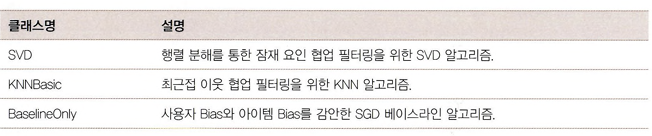

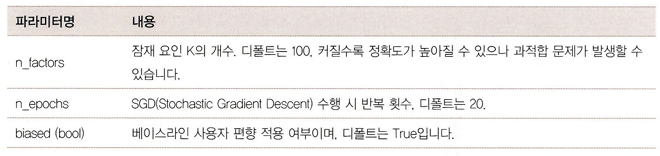

### 베이스라인 평점

- 베이스라인 평점(Baseline Rating)
  - 개인의 성향을 반영해 아이템 평가에 편향성(bias) 요소를 반영하여 평점 부과
  - 전체 평균 평점 + 사용자 편향 점수 + 아이템 편향 점수


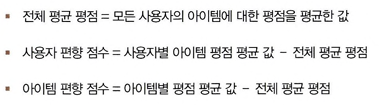

### 교차 검증과 하이퍼 파라미터 튜닝

- Surprise는 교차 검증과 하이퍼 파라미터 튜닝 위해 cross_validate()와 GridSearchCV 클래스 제공

In [ ]:
from surprise.model_selection import cross_validate

# 판다스 DataFrame에서 Surprise 데이터 세트로 데이터 로딩
ratings = pd.read_csv('ratings.csv') # reading data in pandas df
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

algo = SVD(random_state=0)
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8688  0.8809  0.8679  0.8758  0.8726  0.8732  0.0048  
MAE (testset)     0.6697  0.6765  0.6686  0.6715  0.6695  0.6712  0.0028  
Fit time          1.47    2.20    1.47    1.48    1.51    1.63    0.29    
Test time         0.13    0.39    0.11    0.12    0.13    0.18    0.11    


{'test_rmse': array([0.86875695, 0.88092589, 0.86790862, 0.87578182, 0.87258328]),
 'test_mae': array([0.66974362, 0.67645239, 0.66859186, 0.67147973, 0.6695167 ]),
 'fit_time': (1.4678387641906738,
  2.1968154907226562,
  1.4722561836242676,
  1.4777154922485352,
  1.5146026611328125),
 'test_time': (0.12622952461242676,
  0.3939554691314697,
  0.10954570770263672,
  0.11505842208862305,
  0.13121795654296875)}

In [ ]:
from surprise.model_selection import GridSearchCV

# 최적화할 파라미터를 딕셔너리 형태로 지정.
param_grid = {'n_epochs': [20, 40, 60], 'n_factors': [50, 100, 200] }

# CV를 3개 폴드 세트로 지정, 성능 평가는 rmse, mse로 수행하도록 GridSearchCV 구성
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

# 최고 RMSE Evaluation 점수와 그때의 하이퍼 파라미터
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.8776388808022743
{'n_epochs': 20, 'n_factors': 50}


### Surprise를 이용한 개인화 영화 추천 시스템 구축

In [ ]:
# 다음 코드는 train_test_split( )으로 분리되지 않는 데이터 세트에 fit( )을 호출해 오류가 발생합니다.
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
algo = SVD(n_factors=50, random_state=0)
algo.fit(data)

AttributeError: 'DatasetAutoFolds' object has no attribute 'n_users'

- 데이터 세트 전체를 학습 데이터로 사용하려면 DatasetAutoFolds 클래스 이용
- 객체 생성 후, build_full_trainset() 호출하면 전체 데이터를 학습 데이터 세트로 만들 수 있음

In [ ]:
from surprise.dataset import DatasetAutoFolds

reader = Reader(line_format='user item rating timestamp', sep=',', rating_scale=(0.5, 5))
# DatasetAutoFolds 클래스를 ratings_noh.csv 파일 기반으로 생성.
data_folds = DatasetAutoFolds(ratings_file='ratings_noh.csv', reader=reader)

#전체 데이터를 학습데이터로 생성함.
trainset = data_folds.build_full_trainset()

In [ ]:
algo = SVD(n_epochs=20, n_factors=50, random_state=0)
algo.fit(trainset)

In [ ]:
# 영화에 대한 상세 속성 정보 DataFrame로딩
movies = pd.read_csv('movies.csv')

# userId=9 의 movieId 데이터 추출하여 movieId=42 데이터가 있는지 확인.
movieIds = ratings[ratings['userId']==9]['movieId']
if movieIds[movieIds==42].count() == 0:
    print('사용자 아이디 9는 영화 아이디 42의 평점 없음')

print(movies[movies['movieId']==42])

사용자 아이디 9는 영화 아이디 42의 평점 없음
    movieId                   title              genres
38       42  Dead Presidents (1995)  Action|Crime|Drama


In [ ]:
uid = str(9)
iid = str(42)

pred = algo.predict(uid, iid, verbose=True)

user: 9          item: 42         r_ui = None   est = 3.13   {'was_impossible': False}


In [ ]:
def get_unseen_surprise(ratings, movies, userId):
    #입력값으로 들어온 userId에 해당하는 사용자가 평점을 매긴 모든 영화를 리스트로 생성
    seen_movies = ratings[ratings['userId']== userId]['movieId'].tolist()

    # 모든 영화들의 movieId를 리스트로 생성.
    total_movies = movies['movieId'].tolist()

    # 모든 영화들의 movieId중 이미 평점을 매긴 영화의 movieId를 제외하여 리스트로 생성
    unseen_movies= [movie for movie in total_movies if movie not in seen_movies]
    print('평점 매긴 영화수:',len(seen_movies), '추천대상 영화수:',len(unseen_movies), \
          '전체 영화수:',len(total_movies))

    return unseen_movies

unseen_movies = get_unseen_surprise(ratings, movies, 9)

평점 매긴 영화수: 46 추천대상 영화수: 9696 전체 영화수: 9742


In [ ]:
def recomm_movie_by_surprise(algo, userId, unseen_movies, top_n=10):
    # 알고리즘 객체의 predict() 메서드를 평점이 없는 영화에 반복 수행한 후 결과를 list 객체로 저장
    predictions = [algo.predict(str(userId), str(movieId)) for movieId in unseen_movies]

    # predictions list 객체는 surprise의 Predictions 객체를 원소로 가지고 있음.
    # [Prediction(uid='9', iid='1', est=3.69), Prediction(uid='9', iid='2', est=2.98),,,,]
    # 이를 est 값으로 정렬하기 위해서 아래의 sortkey_est 함수를 정의함.
    # sortkey_est 함수는 list 객체의 sort() 함수의 키 값으로 사용되어 정렬 수행.
    def sortkey_est(pred):
        return pred.est

    # sortkey_est( ) 반환값의 내림 차순으로 정렬 수행하고 top_n개의 최상위 값 추출.
    predictions.sort(key=sortkey_est, reverse=True)
    top_predictions= predictions[:top_n]

    # top_n으로 추출된 영화의 정보 추출. 영화 아이디, 추천 예상 평점, 제목 추출
    top_movie_ids = [ int(pred.iid) for pred in top_predictions]
    top_movie_rating = [ pred.est for pred in top_predictions]
    top_movie_titles = movies[movies.movieId.isin(top_movie_ids)]['title']
    top_movie_preds = [ (id, title, rating) for id, title, rating in zip(top_movie_ids, top_movie_titles, top_movie_rating)]

    return top_movie_preds

unseen_movies = get_unseen_surprise(ratings, movies, 9)
top_movie_preds = recomm_movie_by_surprise(algo, 9, unseen_movies, top_n=10)
print('##### Top-10 추천 영화 리스트 #####')

for top_movie in top_movie_preds:
    print(top_movie[1], ":", top_movie[2])

평점 매긴 영화수: 46 추천대상 영화수: 9696 전체 영화수: 9742
##### Top-10 추천 영화 리스트 #####
Usual Suspects, The (1995) : 4.306302135700814
Star Wars: Episode IV - A New Hope (1977) : 4.281663842987387
Pulp Fiction (1994) : 4.278152632122759
Silence of the Lambs, The (1991) : 4.226073566460876
Godfather, The (1972) : 4.1918097904381995
Streetcar Named Desire, A (1951) : 4.154746591122657
Star Wars: Episode V - The Empire Strikes Back (1980) : 4.122016128534504
Star Wars: Episode VI - Return of the Jedi (1983) : 4.108009609093436
Goodfellas (1990) : 4.083464936588478
Glory (1989) : 4.07887165526957


## 9-9. 정리

[추천 시스템]
- 콘텐츠 기반 필터링
  - 아아템을 구성하는 여러 콘텐츠 중 사용자가 좋아하는 콘텐츠를 필터링하여 이에 맞는 아이템 추천
   - 피처 벡터화
- 협업 필터링
  - 최근접 이웃 협업 필터링
    - 사용자 기반
    - 아이템 기반 : 특정 아이템과 가장 근접하게 유사한 다른 아이템 추천하는 방식, 코사인 유사도 사용
  - 잠재 요인 협업 필터링
    - 많은 추천 시스템에서 활용
    - 사용자-아이템 펴엄 행렬 데이터에 숨어있는 잠재 요인을 추출하여 사용자가 아직 평점을 매기지 않은 아이템에 대한 평점을 예측하여 추천에 반영하는 방식
    - 잠재 요인 추출 위해 행렬 분해
- Surprise 패키지
